In [1]:
### Important notice : this notebook works under @dft_for_sm conda env...

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
import dft_descriptors.prepocessing as pp
from dft_descriptors import numbering_CO as nb

In [7]:
#### determine if ligand is NHC, Phosphine, Diphosphine or other ####
def lig_type(list_lig):
    lig_type = []
    for smi in list_lig:
        m = Chem.MolFromSmiles(smi)
        if m.HasSubstructMatch(Chem.MolFromSmiles('N[C]N')):
            typ = 'NHC'
            if m.HasSubstructMatch(Chem.MolFromSmiles('P')):
                typ = 'mixed'
        elif m.HasSubstructMatch(Chem.MolFromSmiles('P')):
            typ = 'Phos'
            if len(m.GetSubstructMatches(Chem.MolFromSmiles('P'))) == 2:
                typ = 'DiPhos'
                if len(m.GetSubstructMatches(Chem.MolFromSmiles('P'))) > 2:
                    typ = 'mixed Phos'
        else:
            typ = 'other'
        lig_type.append(typ)
    return lig_type

def smi_L_type(smi):
    m = Chem.MolFromSmiles(smi)
    if m.HasSubstructMatch(Chem.MolFromSmiles('N[C]N')):
        typ = 'NHC'
    elif m.HasSubstructMatch(Chem.MolFromSmiles('P')):
        typ = 'Phos'
        if len(m.GetSubstructMatches(Chem.MolFromSmiles('P'))) == 2:
            typ = 'DiPhos'
    else:
        typ = 'other'
    return typ



#### PHOS ####
def number_Phos(smi):
    m = Chem.MolFromSmiles(smi)
    i = 1
    for c in m.GetSubstructMatches(Chem.MolFromSmiles('PC')): 
        for at in m.GetAtoms():
            a = at.GetIdx()
            if a in c and at.GetSymbol() == 'P':
                nb.reset_atom_map(m, 0)
                at.SetAtomMapNum(0)
            elif a in c and at.GetSymbol() != 'P':
                nb.reset_atom_map(m, i)
                at.SetAtomMapNum(i)
                i += 1 
    return m






#### DIPHOS ####
def number_DiPhos(smi):
    m = Chem.MolFromSmiles(smi)
    ip = 0
    ic1 = 2
    ic2 = 5
    for c in m.GetSubstructMatches(Chem.MolFromSmiles('P')): 
        for at in m.GetAtoms():
            a = at.GetIdx()
            if a in c and at.GetSymbol() == 'P':
                nb.reset_atom_map(m, ip)
                at.SetAtomMapNum(ip)
                ip += 1
                
    for c in m.GetSubstructMatches(Chem.MolFromSmiles('PC')): 
        at_map_c = [m.GetAtoms()[i].GetAtomMapNum() for i in c]
        for at in m.GetAtoms():
            a = at.GetIdx()
            if a in c:
                if at.GetSymbol() != 'P':
                    if 0 in at_map_c:
                        nb.reset_atom_map(m, ic1)
                        at.SetAtomMapNum(ic1)
                        ic1 += 1
                    elif 1 in at_map_c:
                        nb.reset_atom_map(m, ic2)
                        at.SetAtomMapNum(ic2)
                        ic2 += 1
    return m


#### NHC ####
def number_NHC(smi):
    m = Chem.MolFromSmiles(smi)
    if m.HasSubstructMatch(Chem.MolFromSmiles('N1[C]NCC1')):
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('N[C]N')):
                nb.reset_atom_map(m, 0)
                m.GetAtoms()[c[0]].SetAtomMapNum(0)

        iN = 1
        for N in m.GetSubstructMatches(Chem.MolFromSmiles('N')):
            if N[0] in m.GetSubstructMatch(Chem.MolFromSmiles('N[C]N')):
                nb.reset_atom_map(m, iN)
                m.GetAtoms()[N[0]].SetAtomMapNum(iN)
                iN +=1 
        
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('C1N[C]NC1')):
                if m.GetAtoms()[c[0]].GetAtomMapNum() > 0:
                    nb.reset_atom_map(m, iN)
                    m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                    iN +=1
      
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('C1N(C)[C]N(C)C1')):
                if m.GetAtoms()[c[0]].GetAtomMapNum() >= 5:
                    nb.reset_atom_map(m, iN)
                    m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                    iN +=1
            
    elif m.HasSubstructMatch(Chem.MolFromSmiles('N1[C]NC=C1')): 
        num = len(m.GetSubstructMatches(Chem.MolFromSmiles('C1=CN[C]N1')))
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('N[C]N')):
                nb.reset_atom_map(m, 0)
                m.GetAtoms()[c[0]].SetAtomMapNum(0)

        iN = 1
        for N in m.GetSubstructMatches(Chem.MolFromSmiles('N')):
            if num ==1 :
                if N[0] in m.GetSubstructMatch(Chem.MolFromSmiles('N[C]N')):
                    nb.reset_atom_map(m, iN)
                    m.GetAtoms()[N[0]].SetAtomMapNum(iN)
                    iN +=1 
            else:
                if N[0] in find_good_match(m, 0, 'N[C]N'):
                    nb.reset_atom_map(m, iN)
                    m.GetAtoms()[N[0]].SetAtomMapNum(iN)
                    iN +=1 
                 
        
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if num ==1 :
                if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('C1=CN[C]N1')):
                    if m.GetAtoms()[c[0]].GetAtomMapNum() > 0:
                        nb.reset_atom_map(m, iN)
                        m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                        iN +=1
            else:
                if c[0] in find_good_match(m, 0, 'C1=CN[C]N1'):
                    if m.GetAtoms()[c[0]].GetAtomMapNum() > 0:                    
                        nb.reset_atom_map(m, iN)
                        m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                        iN +=1
                    
      
        for c in m.GetSubstructMatches(Chem.MolFromSmiles('C')):
            if num ==1 :            
                if c[0] in m.GetSubstructMatch(Chem.MolFromSmiles('C1=CN(C)[C]N1(C)')):
                    if m.GetAtoms()[c[0]].GetAtomMapNum() >= 5:
                        nb.reset_atom_map(m, iN)
                        m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                        iN +=1
            elif num ==2 :            
                if c[0] in find_good_match(m, 0, 'C1=CN(C)[C]N1(C)'):
                    if m.GetAtoms()[c[0]].GetAtomMapNum() >= 5:
                        nb.reset_atom_map(m, iN)
                        m.GetAtoms()[c[0]].SetAtomMapNum(iN)
                        iN +=1
    return m


#### UTILS ####
def find_good_match(m, at_idx, frag):
    for match in m.GetSubstructMatches(Chem.MolFromSmiles(frag)):
        for idx in match:
            if m.GetAtoms()[idx].GetAtomMapNum() == at_idx:
                good_match = match
    return good_match

In [8]:
df = pd.read_csv('../data_csv/Data_test11032021.csv', sep = ',')
df = df[df['Ligand effectif'].notna()]
df = pp.preprocess(df)

# generate numbering for all categories

In [9]:
unik_lig = np.unique(df["Ligand effectif"])
can_unik_lig = np.unique([Chem.CanonSmiles(smi) for smi in unik_lig])

counts= []
for typ in np.unique(lig_type(can_unik_lig)):
    c = lig_type(can_unik_lig).count(typ), typ
    counts.append(c)
    
print(counts)

phos = [can_unik_lig[i] for i in range(len(can_unik_lig)) if lig_type(can_unik_lig)[i] == 'Phos']
diphos = [can_unik_lig[i] for i in range(len(can_unik_lig)) if lig_type(can_unik_lig)[i] == 'DiPhos']
nhc = [can_unik_lig[i] for i in range(len(can_unik_lig)) if lig_type(can_unik_lig)[i] == 'NHC']

mols = [Chem.MolFromSmiles(smi)  for smi in can_unik_lig]

types = lig_type(can_unik_lig)
#Chem.Draw.MolsToGridImage(mols, legends = lig_type(can_unik_lig), maxMols = 200, subImgSize=(400, 400))

[(26, 'DiPhos'), (16, 'NHC'), (37, 'Phos'), (6, 'other')]


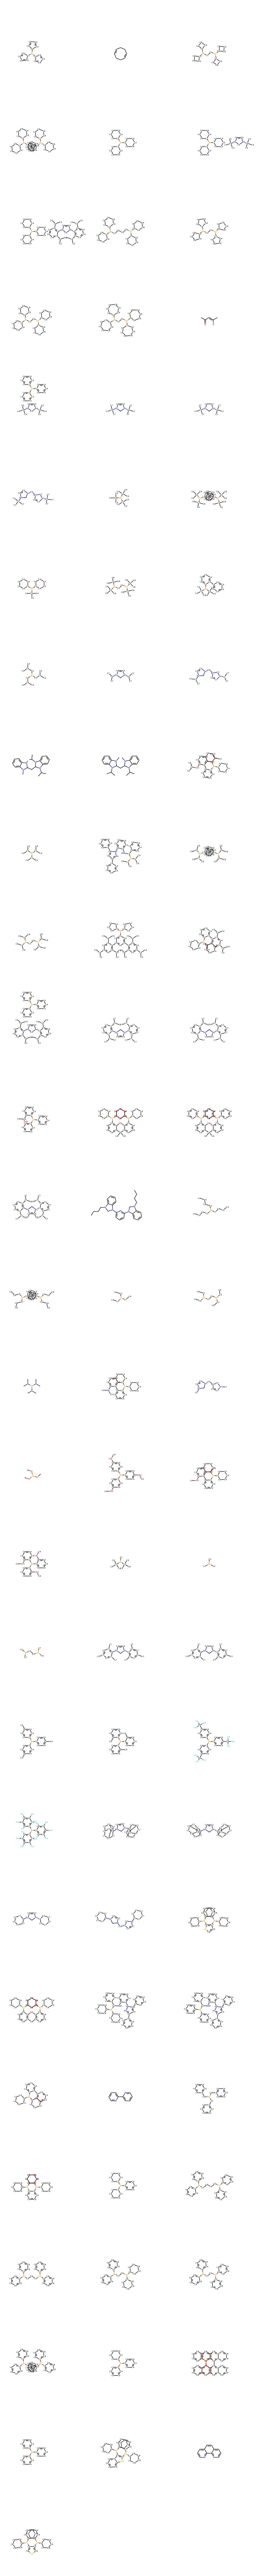

In [10]:
numbered_mols = []
for i, smi in enumerate(can_unik_lig):
    typ = types[i]
    if typ == 'Phos':
        num_mol = number_Phos(smi)
    elif typ == 'DiPhos':
        num_mol = number_DiPhos(smi)
    elif typ == 'NHC':
        num_mol = number_NHC(smi)
    else:
        num_mol = Chem.MolFromSmiles(smi)
    numbered_mols.append(num_mol)

Chem.Draw.MolsToGridImage(numbered_mols, maxMols = 200, subImgSize=(400, 400))

In [11]:
num_smis = [Chem.MolToSmiles(i) for i in numbered_mols]

In [12]:
num_df  = pd.DataFrame({'react' : can_unik_lig,
                        'C0C7_num' : num_smis},
                        columns = ['react', 'C0C7_num'])

In [13]:
num_df

,react,C0C7_num
0,C1=CC(P(C2C=CC=C2)C2C=CC=C2)C=C1,P([CH:1]1[CH:4]=[CH:4][CH:4]=[CH:4]1)([CH:2]1[...
1,C1=CCCC=CCC1,C1=CCCC=CCC1
2,C1CC(P(CCP(C2CCC2)C2CCC2)C2CCC2)C1,P([CH:2]1[CH2:8][CH2:8][CH2:8]1)([CH2:3][CH2:5...
3,C1CCC(P(C2CCCCC2)C23C4C5C6C2[Fe]56432789C3C2C7...,P([CH:2]1[CH2:8][CH2:8][CH2:8][CH2:8][CH2:8]1)...
4,C1CCC(P(C2CCCCC2)C2CCCCC2)CC1,P([CH:1]1[CH2:4][CH2:4][CH2:4][CH2:4][CH2:4]1)...
...,...,...
80,c1ccc(P(c2ccccc2)c2ccc3ccccc3c2-c2c(P(c3ccccc3...,P([c:2]1[cH:8][cH:8][cH:8][cH:8][cH:8]1)([c:3]...
81,c1ccc(P(c2ccccc2)c2ccccc2)cc1,P([c:1]1[cH:4][cH:4][cH:4][cH:4][cH:4]1)([c:2]...
82,c1ccc2c(P(C3CCCCC3)C3CCCCC3)c(P(C3CCCCC3)C3CCC...,P([c:2]1[c:5]([P:1]([CH:6]2[CH2:8][CH2:8][CH2:...
83,c1cnc2c(c1)ccc1cccnc12,c1cnc2c(c1)ccc1cccnc12


In [14]:
num_df.to_csv("../data_csv/num_ligands.csv", sep=',',index=False)

In [15]:
num_df["C0C7_num"]

0     P([CH:1]1[CH:4]=[CH:4][CH:4]=[CH:4]1)([CH:2]1[...
1                                          C1=CCCC=CCC1
2     P([CH:2]1[CH2:8][CH2:8][CH2:8]1)([CH2:3][CH2:5...
3     P([CH:2]1[CH2:8][CH2:8][CH2:8][CH2:8][CH2:8]1)...
4     P([CH:1]1[CH2:4][CH2:4][CH2:4][CH2:4][CH2:4]1)...
                            ...                        
80    P([c:2]1[cH:8][cH:8][cH:8][cH:8][cH:8]1)([c:3]...
81    P([c:1]1[cH:4][cH:4][cH:4][cH:4][cH:4]1)([c:2]...
82    P([c:2]1[c:5]([P:1]([CH:6]2[CH2:8][CH2:8][CH2:...
83                               c1cnc2c(c1)ccc1cccnc12
84    P([c:2]1[c:5]([P:1]([CH:6]2[CH2:8][CH2:8][CH2:...
Name: C0C7_num, Length: 85, dtype: object

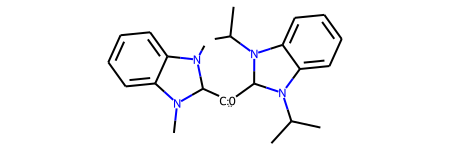

In [21]:
Chem.MolFromSmiles("CC(C)N1c2ccccc2N(C(C)C)[CH:1]1[C:0]C1N(C)c2ccccc2N1C")

In [73]:
m = Chem.MolFromSmiles("Cc1ccccc1P(c1ccccc1C)c1ccccc1C")
for at in m.GetAtoms():
    at.SetAtomMapNum(8)
Chem.MolToSmiles(m)

'[CH3:8][c:8]1[cH:8][cH:8][cH:8][cH:8][c:8]1[P:8]([c:8]1[cH:8][cH:8][cH:8][cH:8][c:8]1[CH3:8])[c:8]1[cH:8][cH:8][cH:8][cH:8][c:8]1[CH3:8]'

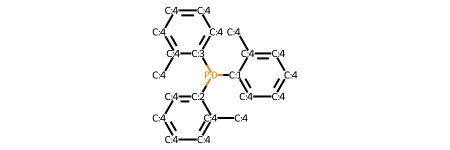

In [76]:
Chem.MolFromSmiles('[CH3:4][c:4]1[cH:4][cH:4][cH:4][cH:4][c:2]1[P:0]([c:1]1[cH:4][cH:4][cH:4][cH:4][c:4]1[CH3:4])[c:3]1[cH:4][cH:4][cH:4][cH:4][c:4]1[CH3:4]')
